In [1]:
import math
import numpy as np
import process_csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time
import sklearn
import tensorflow as tf
from tensorflow import keras

In [2]:
directory = "./Minute_BTC"
data = process_csv.csv_2np(directory)

In [3]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)

def inverse_difference(last_ob, value):
	return value + last_ob

def tanh_normalization(data):
    data = np.array(data)
    m = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    data = 0.5 * (np.tanh(0.01 * ((data - m) / std)) + 1)
    return data, m, std 

def inv_tanh_normalization(data, mean, std_dev):
    data = (data / 0.5) - 1
    data = np.arctanh(data)
    data = data * std_dev / 0.01
    data = data + mean
    return data

### Primero se diferencia para eliminar la tendencia de la serie temporal, de esta forma la red neuronal no tiene que aprender la tendencia. Después se normaliza para que tenga promedio cero y varianza 1

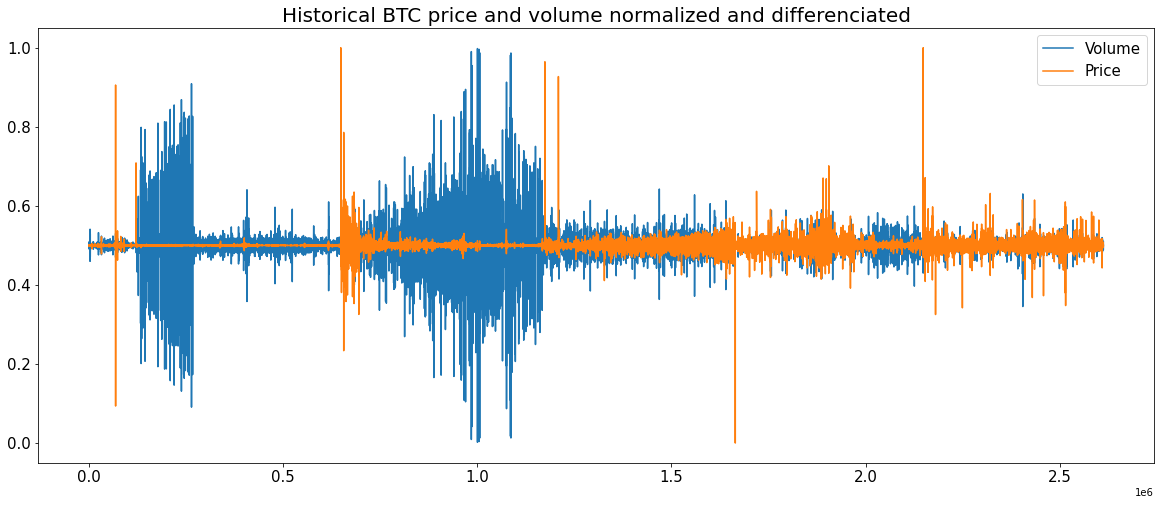

In [4]:
new_data =np.empty([len(data[:, 0])-1, 2])
new_data[:, 0] = difference(data[:, 0])
new_data[:, 1] = difference(data[:, 1])
# scaler_price = MinMaxScaler().fit(new_data[:, 0].reshape(-1,1))
# new_data[:, 0] = scaler_price.transform(new_data[:, 0].reshape(-1,1))[:,0]
# scaler_volume = MinMaxScaler().fit(new_data[:, 1].reshape(-1,1))
# new_data[:, 1] = scaler_volume.transform(new_data[:, 1].reshape(-1,1))[:,0]
new_data[:, 0], price_mean, price_std_dev = tanh_normalization(new_data[:, 0])
new_data[:, 1], volume_mean, volume_std_dev = tanh_normalization(new_data[:, 1])
plt.figure(1, figsize=(20,8))
plt.plot(new_data[:,1], label="Volume")
plt.plot(new_data[:,0], label="Price")
plt.legend(fontsize = 15)
plt.title('Historical BTC price and volume normalized and differenciated', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);


In [5]:
series, x, y = process_csv.dataset(new_data, [], n_steps=60, n_predictions=10, shuffle=False)
size_x = len(x)
x_train = x[:math.ceil(size_x*0.7), :, :]
x_val = x[math.floor(size_x*0.7) : math.ceil(size_x*0.9), :, :]
x_test = x[math.floor(size_x*0.9) :, :, :]
y_train = y[:math.ceil(size_x*0.7), :, :]
y_val = y[math.floor(size_x*0.7) : math.ceil(size_x*0.9), :, :]
y_test = y[math.floor(size_x*0.9) :, :, :]
print(x_val.shape)
print(y_val.shape)
print(x_train.shape)
print(y_train.shape)

(8707, 60, 2)
(8707, 60, 10)
(30471, 60, 2)
(30471, 60, 10)


#### Custom loss function

In [6]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [11]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 2]),    
    keras.layers.GRU(64, return_sequences=True, input_shape=[None, 2]),
    
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
opt = tf.keras.optimizers.Adam()
model.compile(loss="mse", optimizer= opt, metrics=[last_time_step_mse])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 20)          180       
_________________________________________________________________
gru_1 (GRU)                  (None, None, 64)          16512     
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 10)          650       
Total params: 17,342
Trainable params: 17,342
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
953/953 [==============================] - 22s 23ms/step - loss: 0.0028 - last_time_step_mse: 0.0022 - val_loss: 1.2405e-05 - val_last_time_step_mse: 1.0809e-05
Epoch 2/3
953/953 [==============================] - 21s 22ms/step - loss: 9.8674e-06 - last_time_step_mse: 8.2460e-06 - val_loss: 1.1640e-05 - val_last_time_step_mse: 1.0787e-05
Epoch 3/3
953/953 [==============================] - 23s 24ms/step - loss: 9.6588e-06 - last_time_step_mse: 8.2227e-06 - val_loss: 1.1668e-05 - val_last_time_step_mse: 1.0838e-05
68.56133103370667
Train Loss:  8.22267793409992e-06
Validation Loss:  1.0837779882422183e-05


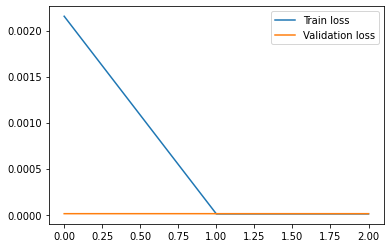

In [12]:
epochs = 3
t0 = time.time()
history = model.fit(x_train, y_train[:, 3::2], epochs=epochs,
                    validation_data=(x_val, y_val[:, 3::2]))
# history = model.fit(x_train, y_train, epochs=epochs,
#                     validation_data=(x_val, y_val))
t1 = time.time() - t0
plt.plot(np.arange(0,epochs,1),history.history['last_time_step_mse'], label='Train loss')
plt.plot(np.arange(0,epochs,1),history.history['val_last_time_step_mse'], label='Validation loss')
plt.legend()
print(t1)
print('Train Loss: ', history.history['last_time_step_mse'][-1])
print('Validation Loss: ', history.history['val_last_time_step_mse'][-1])

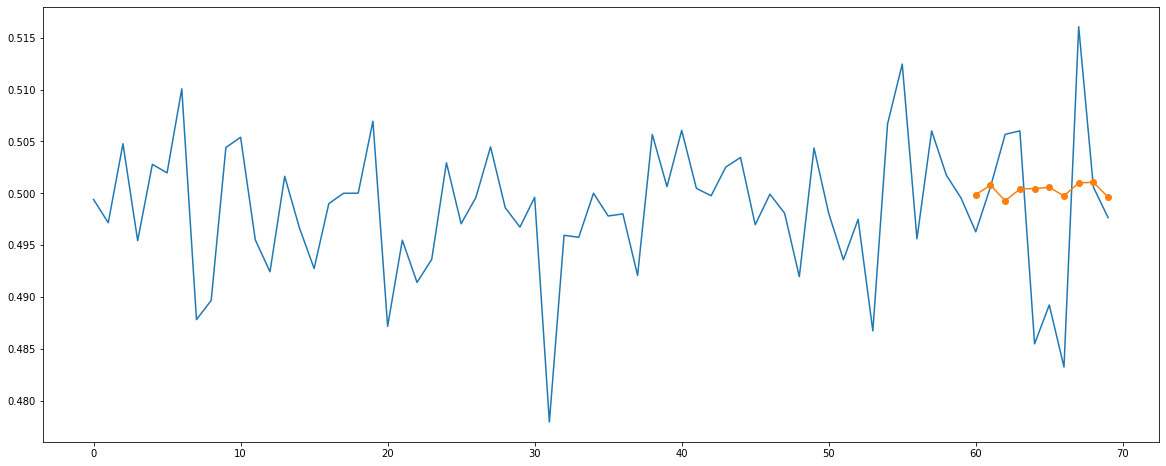

In [13]:
plt.figure(figsize=(20,8))
x_plot = x_val[1000, :, 0]
y_plot = y_val[1000, -1, :]
x_pred = np.empty((1,60,2))
x_pred[0, :, :] = x_val[1000, :, :]
y_pred = model.predict(x_pred)[0,-1,:]
x_plot = np.concatenate((x_plot,y_plot))
plt.plot(x_plot)
plt.plot(range(60,70),y_pred, '-o')

In [14]:
history.history

{'loss': [0.002756500616669655, 9.867374501482118e-06, 9.658755516284145e-06],
 'last_time_step_mse': [0.002155131660401821,
  8.246018296631519e-06,
  8.22267793409992e-06],
 'val_loss': [1.2404731933202129e-05,
  1.163976685347734e-05,
  1.1668368642858695e-05],
 'val_last_time_step_mse': [1.0808590559463482e-05,
  1.0787413884827401e-05,
  1.0837779882422183e-05]}